In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-insurance-price-prediction/Medical_insurance.csv


Importing necessary libraries

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Reading data

In [3]:
df = pd.read_csv('/kaggle/input/medical-insurance-price-prediction/Medical_insurance.csv')

In [4]:
df.sample(10)

,age,sex,bmi,children,smoker,region,charges
2296,22,male,28.310,1,no,northwest,2639.04290
1177,40,female,27.400,1,no,southwest,6496.88600
2141,31,male,27.645,2,no,northeast,5031.26955
1614,41,female,31.635,1,no,northeast,7358.17565
1129,19,female,18.600,0,no,southwest,1728.89700
989,24,female,20.520,0,yes,northeast,14571.89080
2449,36,male,28.595,3,no,northwest,6548.19505
2152,47,male,32.300,1,no,southwest,8062.76400
1949,50,male,44.770,1,no,southeast,9058.73030
2731,30,male,35.300,0,yes,southwest,36837.46700


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [6]:
df['sex'].unique()

array(['female', 'male'], dtype=object)

In [7]:
df['children'].unique()

array([0, 1, 3, 2, 5, 4])

In [8]:
df['smoker'].unique()

array(['yes', 'no'], dtype=object)

In [9]:
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [10]:
df.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


<Axes: xlabel='region', ylabel='charges'>

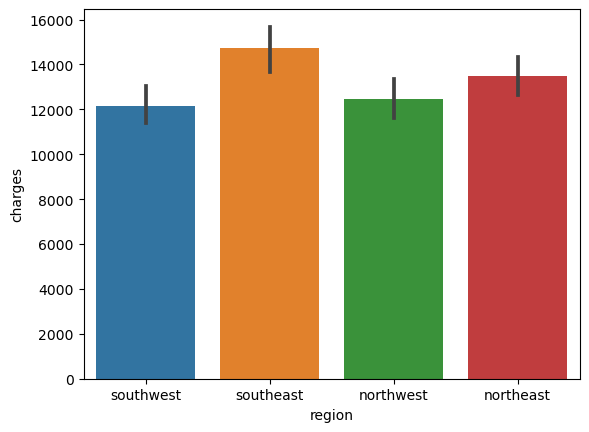

In [11]:
sns.barplot(data = df, y = 'charges', x = 'region')

Southeast region is most costly in terms of medical insurance

<Axes: xlabel='sex', ylabel='charges'>

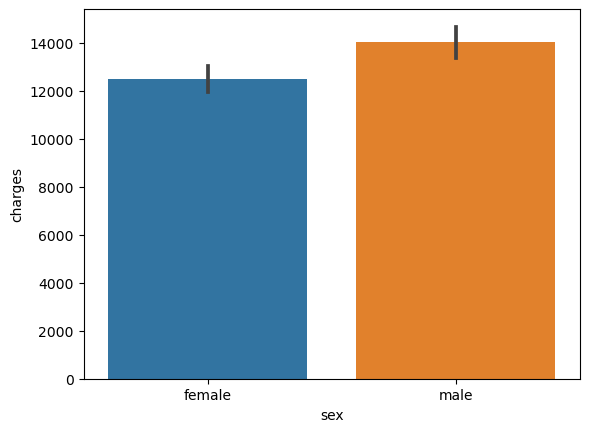

In [12]:
sns.barplot(data = df, y = 'charges', x = 'sex')

Males are charged higher in medical insurance compared to Females

<Axes: xlabel='smoker', ylabel='charges'>

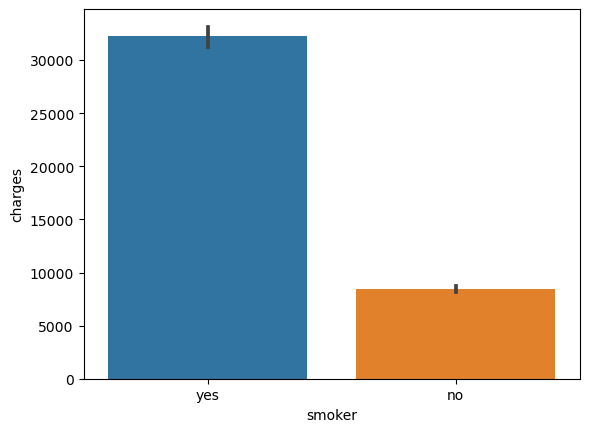

In [13]:
sns.barplot(data = df, y = 'charges', x = 'smoker')

People who smoke are charged higher insurance, which is self-explanatory

<Axes: xlabel='children', ylabel='charges'>

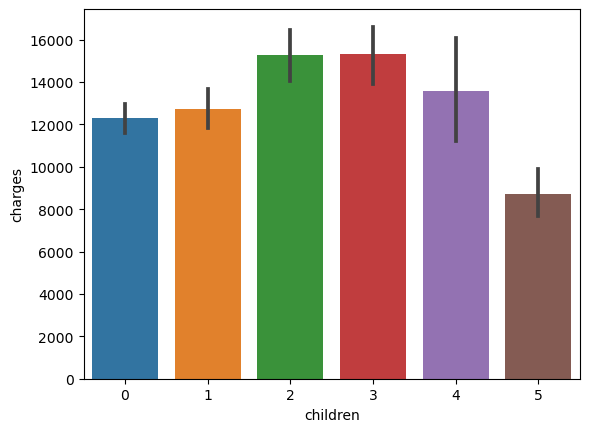

In [14]:
sns.barplot(data = df, y = 'charges', x = 'children')

There is no correlation b/w no. of childeren and insurance price

<Axes: xlabel='children', ylabel='charges'>

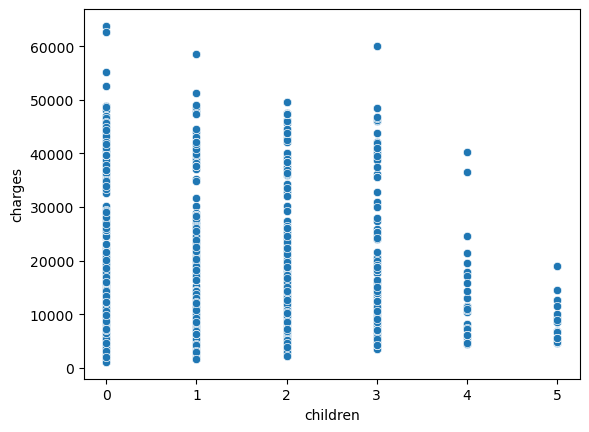

In [15]:
sns.scatterplot(data = df, y = 'charges', x = 'children')

Can be viewed using a scatterplot aswell

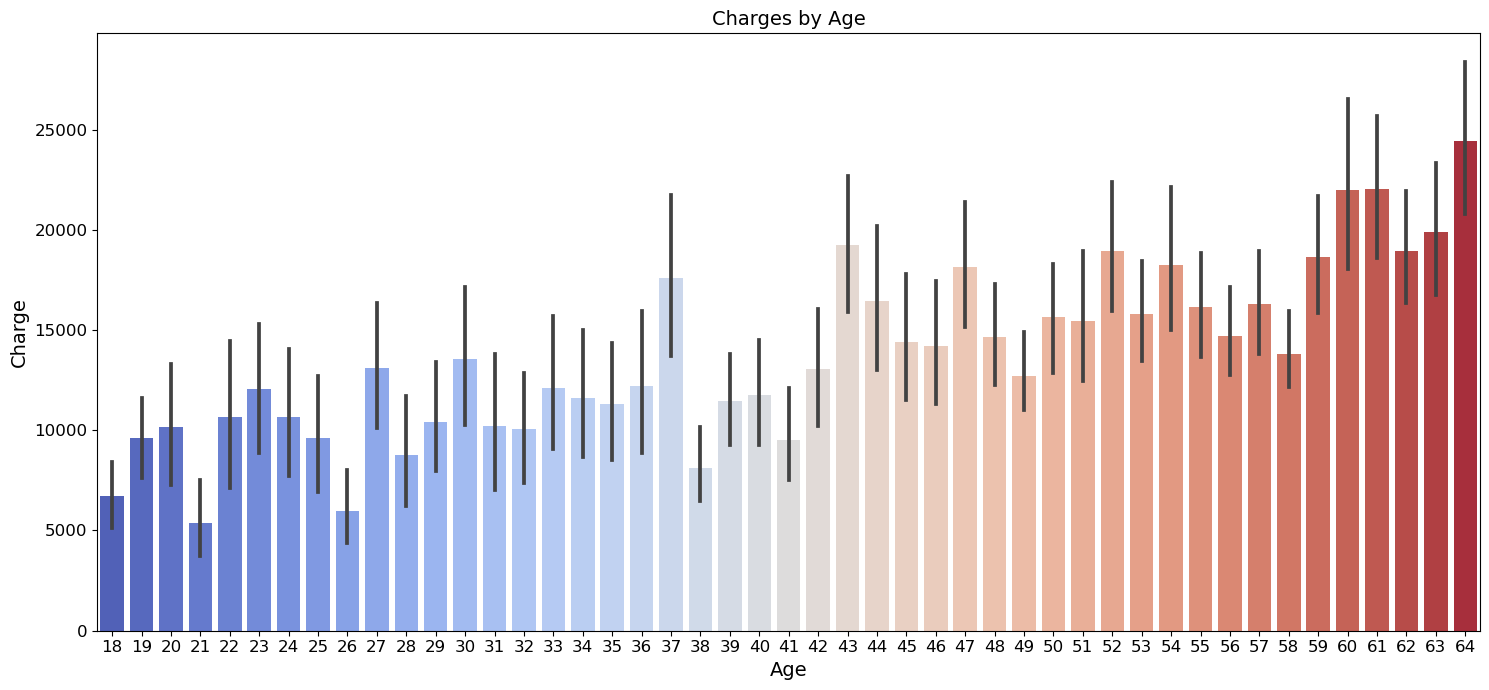

In [16]:
plt.figure(figsize = (15, 7))
plt.title('Charges by Age', fontsize = 14)
sns.barplot(data = df, x = 'age', y = 'charges', palette='coolwarm')
plt.xlabel('Age', fontsize = 14)
plt.ylabel('Charge', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.show()

64 years old person gets charged the highest insurance, which is again self-explanatory

In [17]:
age_bins = [0, 20, 30, 40, 50, 60, 100] 
age_labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61+']  

df['age_group'] = pd.cut(df['age'], bins = age_bins, labels = age_labels, right = False)

df.head()

,age,sex,bmi,children,smoker,region,charges,age_group
0,19,female,27.900,0,yes,southwest,16884.92400,0-20
1,18,male,33.770,1,no,southeast,1725.55230,0-20
2,28,male,33.000,3,no,southeast,4449.46200,21-30
3,33,male,22.705,0,no,northwest,21984.47061,31-40
4,32,male,28.880,0,no,northwest,3866.85520,31-40


Created bins so that visualization is easier to understand, grouping them makes it easier to interpret 

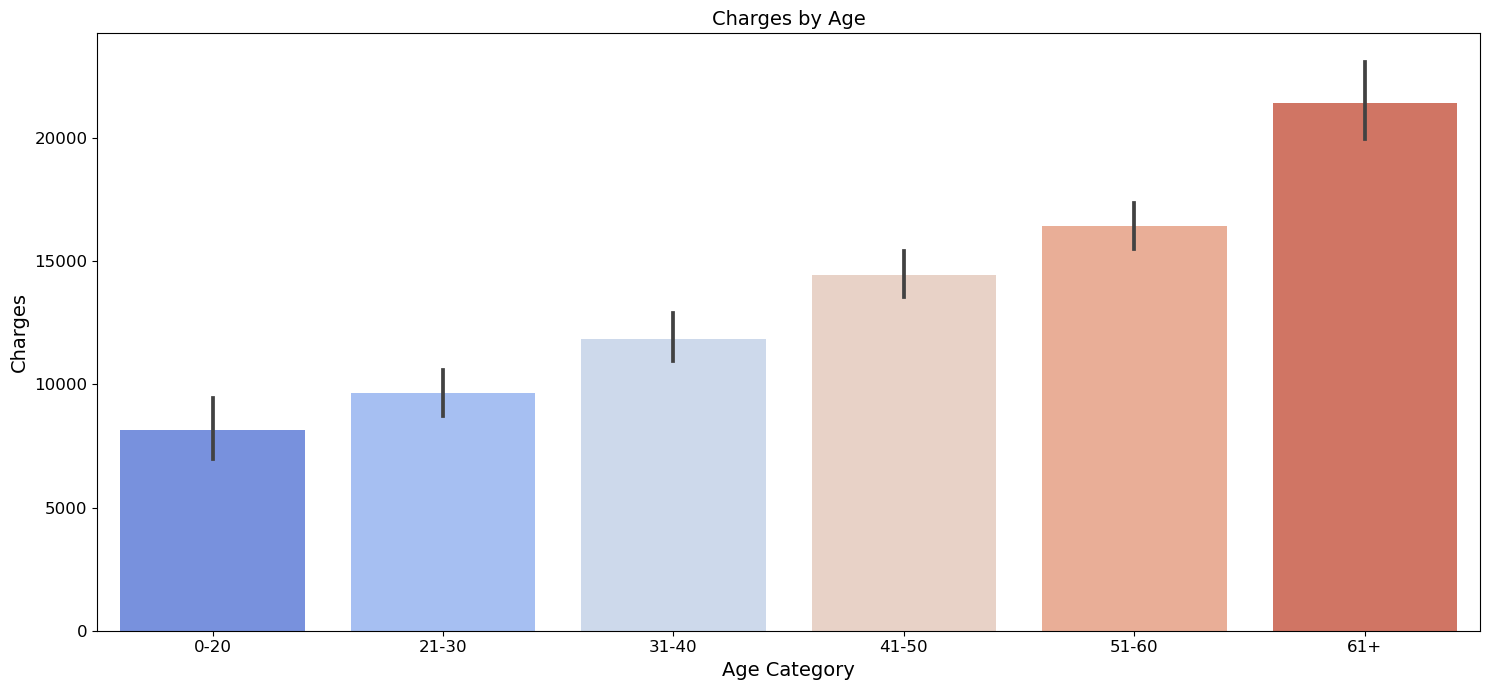

In [18]:
plt.figure(figsize = (15, 7))
plt.title('Charges by Age', fontsize = 14)
sns.barplot(data = df, x = 'age_group', y = 'charges', palette='coolwarm')
plt.xlabel('Age Category', fontsize = 14)
plt.ylabel('Charges', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.show()

In [19]:
bmi_bins = [0, 18.5, 25, 30, 35, 40, 50]  
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese Class I', 'Obese Class II', 'Obese Class III'] 

df['bmi_category'] = pd.cut(df['bmi'], bins = bmi_bins, labels = bmi_labels, right = False)

df.head()

,age,sex,bmi,children,smoker,region,charges,age_group,bmi_category
0,19,female,27.900,0,yes,southwest,16884.92400,0-20,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,0-20,Obese Class I
2,28,male,33.000,3,no,southeast,4449.46200,21-30,Obese Class I
3,33,male,22.705,0,no,northwest,21984.47061,31-40,Normal
4,32,male,28.880,0,no,northwest,3866.85520,31-40,Overweight


Similarly created bins for BMI because BMI is usually measured in these categories so it makes more sense for businesses

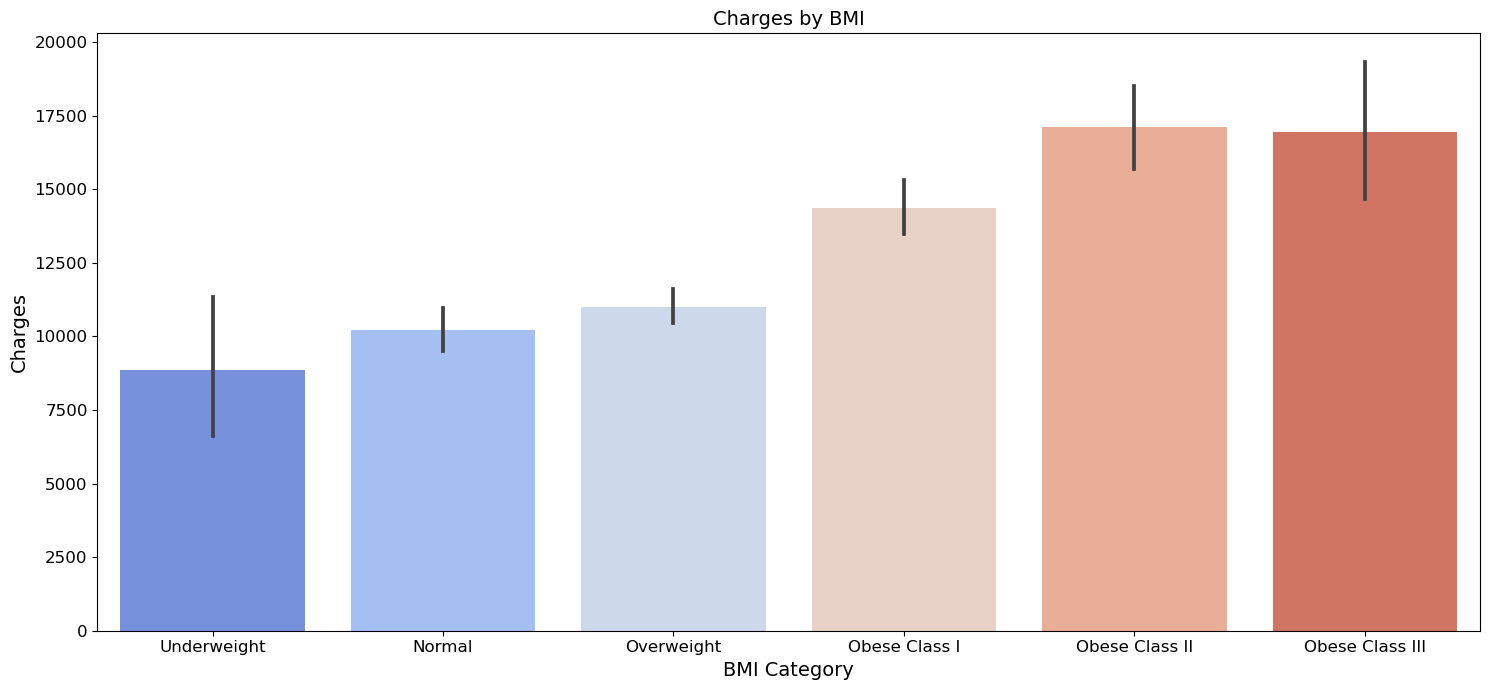

In [20]:
plt.figure(figsize = (15, 7))
plt.title('Charges by BMI', fontsize = 14)
sns.barplot(data = df, x = 'bmi_category', y = 'charges', palette = 'coolwarm')
plt.xlabel('BMI Category', fontsize = 14)
plt.ylabel('Charges', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.show()

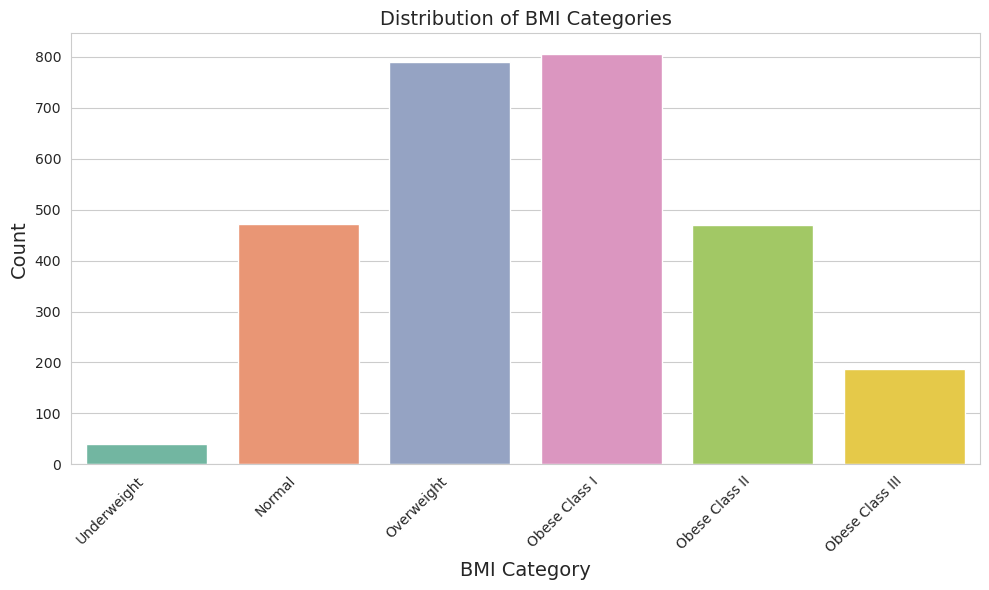

In [21]:
sns.set_style("whitegrid")

plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'bmi_category', palette = 'Set2')
plt.xlabel('BMI Category', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Distribution of BMI Categories', fontsize = 14)
plt.xticks(rotation = 45, ha = 'right', fontsize = 10)
plt.tight_layout()
plt.show()

Most of the people are overweight & obese class I which is not a great sign for medical insurance

In [22]:
corr_mat = df.corr()

/tmp/ipykernel_20/1214047907.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = df.corr()


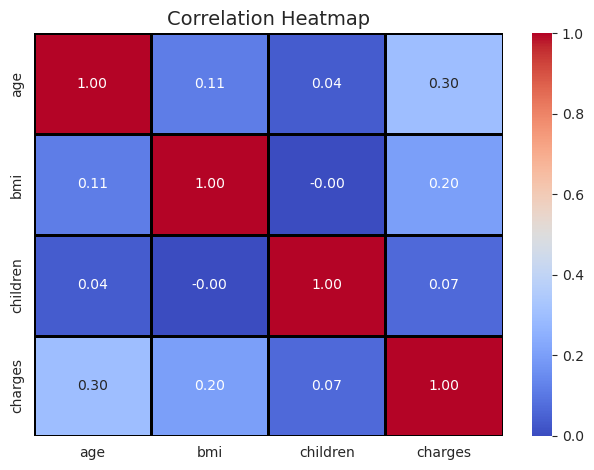

In [23]:
plt.title('Correlation Heatmap', fontsize = 14)
sns.heatmap(corr_mat, annot = True, cmap = 'coolwarm', linewidths = 1, linecolor = 'black', fmt = '.2f')
plt.tight_layout()
plt.show()

Using heatmap one can clearly interpret some points:
- Age and Charges are clearly correlated as Age increases the charge also increases
- BMI and Children are not at all related
- BMI and Charges are also related
- Children and Charges are not related

In [24]:
df.head()

,age,sex,bmi,children,smoker,region,charges,age_group,bmi_category
0,19,female,27.900,0,yes,southwest,16884.92400,0-20,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,0-20,Obese Class I
2,28,male,33.000,3,no,southeast,4449.46200,21-30,Obese Class I
3,33,male,22.705,0,no,northwest,21984.47061,31-40,Normal
4,32,male,28.880,0,no,northwest,3866.85520,31-40,Overweight


Do not require bins for further processing so removing them

In [25]:
df = df.iloc[:, 0:7]

Encoding

In [26]:
df['smoker'] = df['smoker'].replace({'yes' : 1, 'no' : 0})
df['sex'] = df['sex'].replace({'male' : 1, 'female' : 0})

In [27]:
df.drop(columns = 'region', inplace = True)

Region is not all contributing to the Y target feature

In [28]:
df.head()

,age,sex,bmi,children,smoker,charges
0,19,0,27.900,0,1,16884.92400
1,18,1,33.770,1,0,1725.55230
2,28,1,33.000,3,0,4449.46200
3,33,1,22.705,0,0,21984.47061
4,32,1,28.880,0,0,3866.85520


In [29]:
X = df.drop(columns = ['charges', 'children', 'sex'])
y = df['charges']

Selected only these 3 features because only they contribute much to the Y target

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [31]:
df = pd.merge(x_test, y_test, how = 'inner', left_index = True, right_index = True)

In [32]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

In [33]:
df['Prediction'] = xgb.predict(x_test)

In [34]:
df.head()

,age,bmi,smoker,charges,Prediction
1106,49,29.925,0,8988.15875,9331.247070
1321,62,26.695,1,28101.33305,28207.871094
2313,57,20.100,0,12032.32600,12109.324219
2274,22,39.500,0,1682.59700,1866.787476
1432,18,38.665,0,3393.35635,3533.201904


In [35]:
print(r2_score(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print('Average Absolute error:', '${:.2f}'.format(mae))

0.9396670314008342
Average Absolute error: $1479.66


Using GridSearchCV to fetch the best parameters and score

In [36]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9]
}

In [37]:
Grid = GridSearchCV(xgb, param_grid, cv = 10, scoring = 'neg_mean_squared_error')

In [38]:
Grid.fit(x_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 300, 500]},
             scoring='neg_mean_squared_error')

In [39]:
best_params = Grid.best_params_
best_score = np.abs(Grid.best_score_)

In [40]:
print(best_params)
print(best_score)

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
9644365.694026949


Now using the best parameter values to create XGBoostRegressor

In [41]:
xgb = XGBRegressor(n_estimators = 500, max_depth = 7, learning_rate = 0.1)
xgb.fit(x_train, y_train)
y_pred1 = xgb.predict(x_test)

In [42]:
df['Prediction-Optimized'] = xgb.predict(x_test)

In [43]:
df.sample(10)

,age,bmi,smoker,charges,Prediction,Prediction-Optimized
821,26,17.670,0,2680.94930,2449.844238,2513.715332
507,21,23.750,0,3077.09550,2783.967285,3066.960693
134,20,28.785,0,2457.21115,1855.519775,2239.873779
233,59,27.500,0,12333.82800,12318.032227,12214.136719
2149,27,26.030,0,3070.80870,3528.569336,3074.809814
1760,20,33.330,0,1391.52870,1951.523560,1275.544678
1229,58,30.305,0,11938.25595,11530.125977,11977.146484
1128,34,32.800,0,14358.36437,5369.840820,5360.046875
2686,45,30.360,1,62592.87309,61399.796875,62156.621094
2434,25,22.515,0,3594.17085,3432.581787,3574.805176


In [44]:
print(r2_score(y_test, y_pred1))
mae1 = mean_absolute_error(y_test, y_pred1)
print("Average Absolute error:", "${:.2f}".format(mae1))

0.9464500320045318
Average Absolute error: $1043.79


- R2 Score increased from 0.9396670314008342 ---> 0.9464500320045318
- Average error in prediction is about 1000 dollars

In [45]:
xgb.predict(pd.DataFrame([[25, 24, 0]], columns = ['age', 'bmi', 'smoker']))

array([4809.1035], dtype=float32)

I entered a sample for a healthy person and the medical insurance is of 4809 dollars which is almost 25 percentile of data, this value is great considering the mean value is around 13500 dollars

In [46]:
xgb.predict(pd.DataFrame([[40, 30, 1]], columns = ['age', 'bmi', 'smoker']))

array([19066.861], dtype=float32)

A person who is 40 years old having a BMI of 30 which is overweight and that too a smoker has to pay around 20k dollars for medical insurance which is very high